# Import Subhalo Properties from Galacticus Output

This notebook demonstrates crating a halo realization from a galacticus output file.

In [11]:
from pyHalo.Halos.galacticus_util.galacticus_util import *
from pyHalo.Halos.galacticus_util.galacticus_nodedata_filter import *
from pyHalo.preset_models import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes


galacticusfile = GalacticusFileReader.read_file("data/TNFW_example.hdf5")

In [12]:
#Create realization from galacticus file
tree_n = 5
mrange = (1E9,1E10)

realization = DMFromGalacticus(0.5,2,galacticusfile,{},mrange,False,None,None,tree_n,include_field_halos=False,rho_s_use_galacticus=True)
subhalos = realization.halos


#Import nodedata from galacticus
nodedata = tabulate_node_data(galacticusfile)

filter_subhalos = nodedata_filter_subhalos(nodedata)
filter_virialized = nodedata_filter_virialized(nodedata)
filter_mass = nodedata_filter_massrange(nodedata,mrange,GalacticusParameters.MASS_BOUND)
filter_tree = nodedata_filter_tree(nodedata,tree_n)

nodedata = nodedata_apply_filter(nodedata,filter_subhalos & filter_virialized & filter_mass & filter_tree)

## Basic tests
Similar tests should be implemented as a unit teswt in the future.

### Comparison between properties from galacticus and properties from realization

In [13]:
print(f"Number of galacticus subhalos {len(nodedata[GalacticusParameters.MASS_BASIC])}")
print(f"Number of realization subhalos {len(subhalos)}")


Number of galacticus subhalos 99
Number of realization subhalos 99


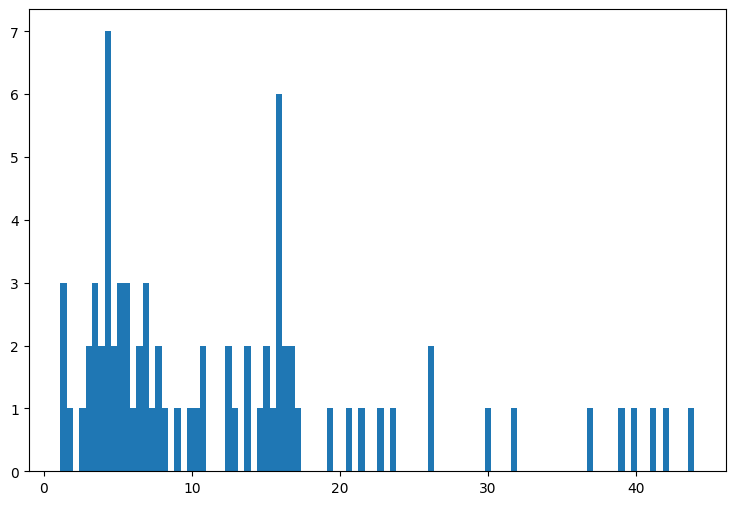

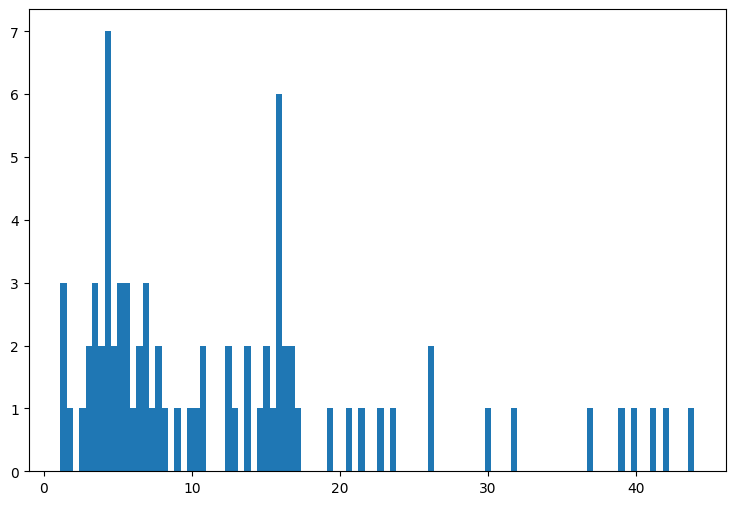

In [14]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

r_trunc_galacticus = nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION] * 1E3
r_trunc_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RT] for sh in subhalos])


ax.hist(r_trunc_realization[r_trunc_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(r_trunc_galacticus[r_trunc_galacticus < 100],bins=100);


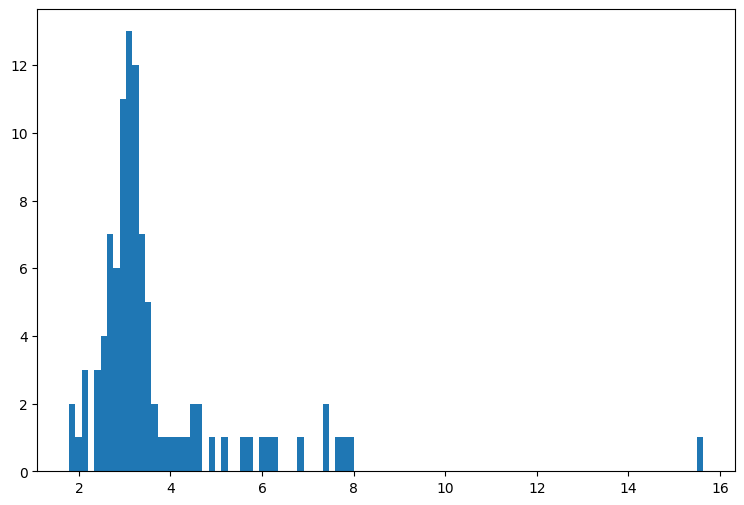

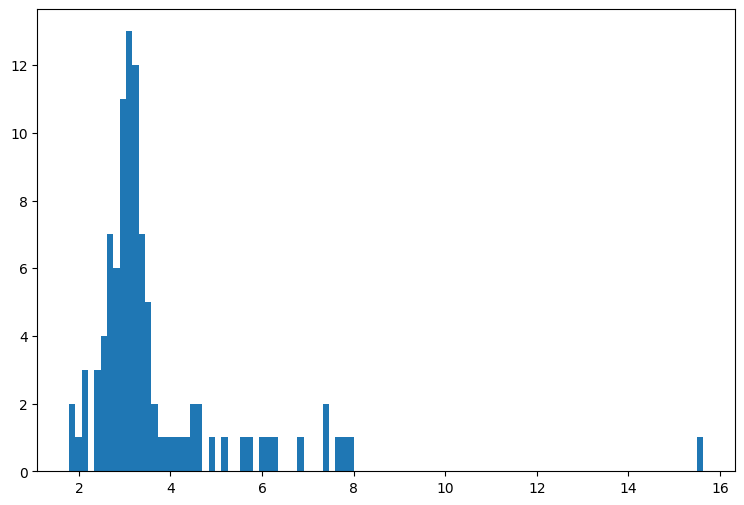

In [15]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rs_galacticus = nodedata[GalacticusParameters.SCALE_RADIUS] * 1E3
rs_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RS] for sh in subhalos])


ax.hist(rs_realization[rs_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rs_galacticus[rs_galacticus < 100],bins=100);

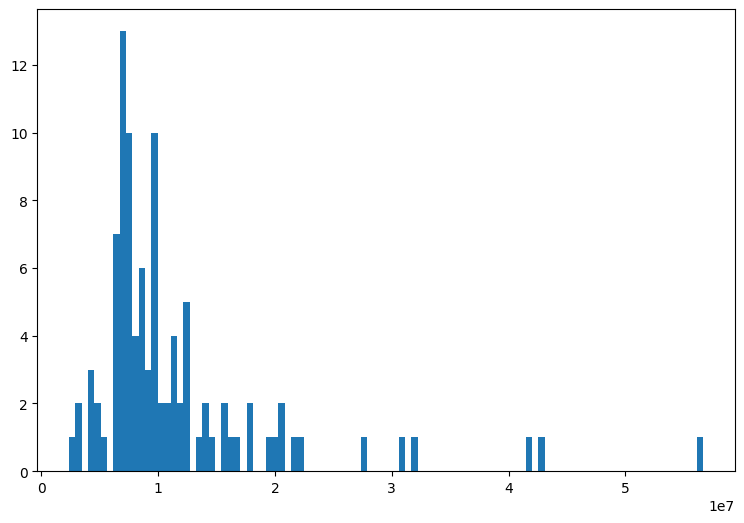

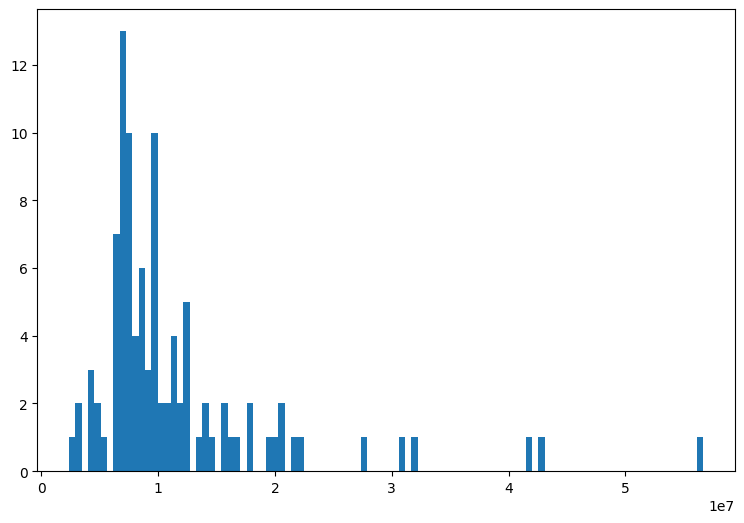

In [16]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rho_s_galacticus = nodedata[GalacticusParameters.TNFW_RHO_S] * 1E3
rho_s_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RHO_S] for sh in subhalos])


ax.hist(rho_s_realization,bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rho_s_realization,bins=100);

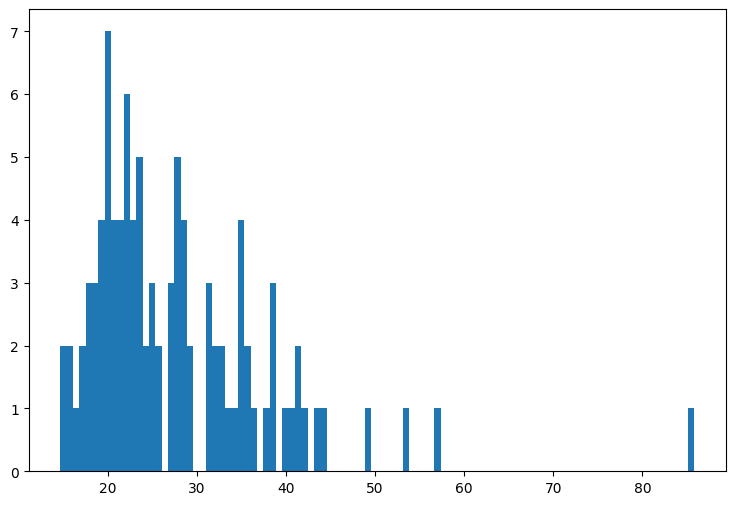

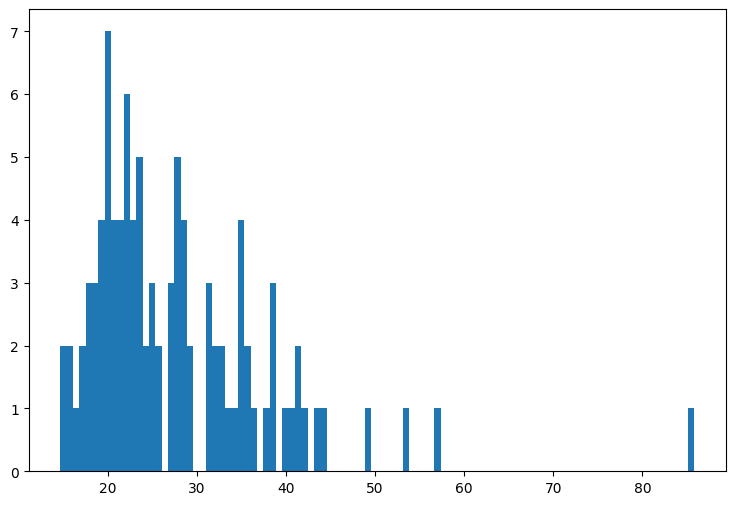

In [17]:
fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

rv_galacticus = nodedata[GalacticusParameters.RVIR] * 1E3
rv_realization = np.asarray([sh.params_physical[TNFWFromParams.KEY_RV] for sh in subhalos])


ax.hist(rv_realization[rv_realization < 100],bins=100);


fig, ax = plt.subplots(figsize = (9, 6))

test:TNFWFromParams = subhalos[0]

ax.hist(rv_galacticus[rv_galacticus < 100],bins=100);

Radius Truncation: 27724.91593273455 [kpc]
Fit metric: 5.731210772269246
Mass Galacticus: 1.23e+09
Mass Pyhalo: 4.52e+09


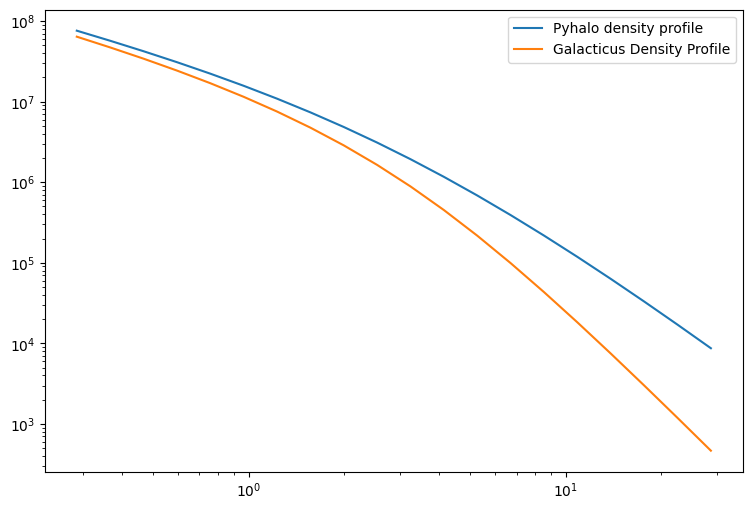

In [24]:
def compare_density(ax:Axes,subhalos:list[TNFWFromParams],nodedata:dict[str,np.ndarray],n:int):
    r = nodedata[GalacticusParameters.DENSITY_PROFILE_RADIUS][n] * 1E3

    subhalo = subhalos[n]
    ax.plot(r,subhalo.density_profile_3d(r),label="Pyhalo density profile")
    ax.plot(r,nodedata[GalacticusParameters.DENSITY_PROFILE][n] / 1E9, label="Galacticus Density Profile")

    #ax.vlines(x=subhalo.params_physical[TNFWFromParams.KEY_RS],ymin=4E3,ymax=1E8,linestyle="dashed")
    #ax.hlines(y=subhalo.params_physical[TNFWFromParams.KEY_RHO_S] / 4, xmin=2E-1,xmax=2E1,linestyles="dashed")

    print(f"Radius Truncation: {subhalo.params_physical[TNFWFromParams.KEY_RT]} [kpc]")
    #print(nodedata[GalacticusParameters.TNFW_RADIUS_TRUNCATION][n])
    print(f"Fit metric: {nodedata['metricTidalTruncationNFW'][n]}")
    print(f"Mass Galacticus: {nodedata[GalacticusParameters.MASS_BOUND][n]:.2e}")
    print(f"Mass Pyhalo: {subhalo.bound_mass:.2e}")
    

fig, ax = plt.subplots(figsize = (9, 6))

compare_density(ax,subhalos,nodedata,98)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

array([[2.31411411e-04, 2.94881775e-04, 3.75760526e-04, ...,
        1.42514303e-02, 1.81602412e-02, 2.31411411e-02],
       [3.14831451e-04, 4.01181847e-04, 5.11216069e-04, ...,
        1.93888386e-02, 2.47067120e-02, 3.14831451e-02],
       [3.60616923e-04, 4.59525130e-04, 5.85561466e-04, ...,
        2.22085287e-02, 2.82997726e-02, 3.60616923e-02],
       ...,
       [1.60336304e-04, 2.04312544e-04, 2.60350403e-04, ...,
        9.87428260e-03, 1.25825513e-02, 1.60336304e-02],
       [2.87121583e-04, 3.65871855e-04, 4.66221422e-04, ...,
        1.76823313e-02, 2.25321525e-02, 2.87121583e-02],
       [4.28076482e-03, 5.45487160e-03, 6.95100746e-03, ...,
        2.63630135e-01, 3.35937287e-01, 4.28076482e-01]])